In [1126]:
#Imports 
import numpy as np
from numpy import random
import itertools
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa import arima_process
from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
import keras
from keras import Sequential
from keras.layers import Activation,Conv2D,MaxPooling2D,Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
import sklearn
from sklearn import metrics
from keras.layers import Activation,Conv2D,MaxPooling2D,Flatten
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [1088]:
#Creating testing and training data sets for AR realizations

def AR_data_creation(p, n_samples, r_len, verbose = False):
    AR_data = np.zeros((p, n_samples, 1,r_len))
    coef_list = []
    for p_index in range(p):
        for i in range(n_samples):
            coefs = (2 * np.random.random(p_index)) - 1
            if p_index > 1:
                inout = np.random.randint(0, high = 2, size= p_index - 1)
                inout = np.r_[(inout,1)]
            else:
                inout = 1
            coefs = coefs * inout        
            coefs = coefs / (sum(abs(coefs)) + 0.0001)
            coefs = np.r_[(1, -coefs)]
            #print(p,coefs)
            coef_list.append(coefs)
            AR_data[p_index][i][0] = statsmodels.tsa.arima_process.arma_generate_sample(
                ar = coefs, ma = [1], nsample = r_len, sigma = 1, burnin = 24)
            #AR_data[p_index][i][1] = statsmodels.tsa.stattools.acf(AR_data[p_index][i][0], nlags = r_len)
            #AR_data[p_index][i][2] = statsmodels.tsa.stattools.pacf(AR_data[p_index][i][0], nlags = r_len - 1)
        if verbose:
            print("Done with", p_index)   
    print("AR: Done")
    return AR_data, coef_list


def CNN_AR_data_creation(p, n_samples, r_len, verbose = False):
    if r_len % 2 == 1:
        r_len -= 1
    
    AR_data = np.zeros((p, n_samples, int(r_len/2),int(r_len/2)))
    for p_index in range(p):
        i = 0 
        while n_samples - 1 > i:
            coefs = (2 * np.random.random(p_index)) - 1
            if p_index > 1:
                inout = np.random.randint(0, high = 2, size= p_index - 1)
                inout = np.r_[(inout,1)]
            else:
                inout = 1
            coefs = coefs * inout        
            coefs = coefs / (sum(abs(coefs)) + 0.0001)
            coefs = np.r_[(1, -coefs)]
            if coefs[-1] < .15:
                pass 
            else:
                i += 1
                realization = statsmodels.tsa.arima_process.arma_generate_sample(
                    ar = coefs, ma = [1], nsample = r_len, sigma = 1, burnin = 24)
                for j in range(int(r_len/2)):
                    AR_data[p_index][i][j] = realization[j:int(r_len/2) + j]
        if verbose:
            print("Done with", p_index)   
    print("CNN: Done")
    return AR_data


def Tree_data_creation(p, n_samples, r_len, lags = 25,verbose = False):
    AR_data = np.zeros((p, n_samples, 2, lags))
    
    for p_index in range(p):
        i = 0 
        while n_samples - 1 > i:
            coefs = (2 * np.random.random(p_index)) - 1
            if p_index > 1:
                inout = np.random.randint(0, high = 2, size= p_index - 1)
                inout = np.r_[(inout,1)]
            else:
                inout = 1
            coefs = coefs * inout        
            coefs = coefs / (sum(abs(coefs)) + 0.0001)
            coefs = np.r_[(1, -coefs)]
            if coefs[-1] < .15:
                pass 
            else:
                i += 1
                realization = statsmodels.tsa.arima_process.arma_generate_sample(
                    ar = coefs, ma = [1], nsample = r_len, sigma = 1, burnin = 24)
            
                AR_data[p_index][i][0] = statsmodels.tsa.stattools.acf(realization, nlags = lags - 1)
                AR_data[p_index][i][1] = statsmodels.tsa.stattools.pacf(realization, nlags = lags - 1)
        if verbose:
            print("Done with", p_index)   
    print("Tree: Done")
    return AR_data



    
    

In [1133]:
#Data parameters 
p = 6
n_train = 12000
n_test = 2000
r_len = 128
lags = 25

In [1134]:
AR_data_train, coef_list_train = AR_data_creation(p,n_train,r_len)
AR_data_test, coef_list_test =  AR_data_creation(p,n_test,r_len)

AR: Done
AR: Done


In [1135]:
CNN_AR_data_train = CNN_AR_data_creation(p,n_train,r_len)
CNN_AR_data_test = CNN_AR_data_creation(p,n_test,r_len)

CNN: Done
CNN: Done


In [1136]:
Tree_data_train = Tree_data_creation(p,n_train,r_len, lags)
Tree_data_test = Tree_data_creation(p,n_test,r_len, lags)

Tree: Done
Tree: Done


In [1143]:
#NN data reshaping
NN_X_train = AR_data_train.reshape(p*n_train, r_len)
NN_X_test = AR_data_test.reshape(p*n_test, r_len)

In [1144]:
#Y
train_a = np.full((n_train,),fill_value=0)
test_a = np.full((n_test,),fill_value=0)
for i in range(1,p):
    train_b = np.full((n_train,),fill_value=i)
    test_b = np.full((n_test,),fill_value=i)
    train_a = np.vstack((train_a,train_b))
    test_a = np.vstack((test_a,test_b))
    
y_train = train_a.ravel()
y_test = test_a.ravel()

Y_train = np_utils.to_categorical(y_train, p)
Y_test = np_utils.to_categorical(y_test, p)

In [1145]:
#CNN data reshaping
CNN_X_train = CNN_AR_data_train.reshape(p*n_train, int(r_len/2),int(r_len/2), 1)
CNN_X_test = CNN_AR_data_test.reshape(p*n_test, int(r_len/2),int(r_len/2), 1)
CNN_X_train.shape[1:]

(64, 64, 1)

In [1146]:
#Tree data reshaping
Tree_X_train = Tree_data_train.reshape(p*n_train, 2 * lags)
Tree_X_test = Tree_data_test.reshape(p*n_test, 2 * lags)

In [1147]:
CNN_model = Sequential()
CNN_model.add(Conv2D(8,(12,12),padding='same',input_shape=CNN_X_train.shape[1:]))
CNN_model.add(Activation('relu'))
CNN_model.add(Conv2D(8,(12,12)))
CNN_model.add(Activation('relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(Dropout(0.25))
CNN_model.add(Conv2D(16,(12,12), padding='same'))
CNN_model.add(Activation('relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(Conv2D(16,(12, 12)))
CNN_model.add(Activation('relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(Dropout(0.25))
#CNN_model.add(Conv2D(32,(4,4), padding='same'))
#CNN_model.add(Activation('relu'))
#CNN_model.add(BatchNormalization())
#CNN_model.add(Conv2D(32,(4, 4)))
#CNN_model.add(Activation('relu'))
#CNN_model.add(BatchNormalization())
#CNN_model.add(MaxPooling2D(pool_size=(2,2)))
#CNN_model.add(Dropout(0.25))
CNN_model.add(Flatten())
CNN_model.add(BatchNormalization())
CNN_model.add(Dense(512))
CNN_model.add(Activation('relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(BatchNormalization())
CNN_model.add(Dense(p))
CNN_model.add(Activation('softmax'))

In [1148]:
NN_model = Sequential()
NN_model.add(Dense(4096, activation = 'relu', input_shape=(r_len,)))
NN_model.add(Dropout(0.5))
NN_model.add(BatchNormalization())
NN_model.add(Dense(2048, activation = 'relu'))
NN_model.add(Dropout(0.5))
NN_model.add(BatchNormalization())
NN_model.add(Dense(1024,activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(BatchNormalization())
NN_model.add(Dense(512,activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(BatchNormalization())
NN_model.add(Dense(256,activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(BatchNormalization())
NN_model.add(Dense(128,activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(BatchNormalization())
NN_model.add(Dense(p,activation='softmax'))

In [1149]:
NN_model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [1150]:
CNN_model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [1162]:
clf = tree.DecisionTreeClassifier(max_depth=12)
clf = clf.fit(Tree_X_train,Y_train)
y_pred = clf.predict(Tree_X_test).argmax(axis=1)

print(clf.score(Tree_X_train, Y_train))
print(clf.score(Tree_X_test, Y_test))


0.9695138888888889
0.94375


In [1163]:
forest = RandomForestClassifier(n_estimators=100, max_depth=12)
forest = forest.fit(Tree_X_train,Y_train)
print(forest.score(Tree_X_train, Y_train))
print(forest.score(Tree_X_test, Y_test))

0.9532083333333333
0.9386666666666666


In [1164]:
y_pred = clf.predict(Tree_X_test).argmax(axis=1)
output = sklearn.metrics.confusion_matrix(y_test, y_pred)

right = 0
count = 0
for i in range(p):
    for j in range(p):
        if i == j:
            right +=  output[i][j]
            count += 1
        if i == j - 1:
            right += output[i][j] 
            count += 1
        if i == j + 1:
            right += output[i][j]
            count += 1
print(count, right)
print(sum(sum(output)))
print(right/sum(sum(output)))
sklearn.metrics.confusion_matrix(y_test, y_pred)

16 11594
12000
0.9661666666666666


array([[1958,    0,    3,   12,   10,   17],
       [   5, 1952,    0,   34,    2,    7],
       [  10,    0, 1941,   23,   15,   11],
       [  19,   39,   34, 1833,   38,   37],
       [  21,    0,   47,   48, 1820,   64],
       [  21,   10,   29,   62,   49, 1829]])

In [1165]:
y_pred = forest.predict(Tree_X_test).argmax(axis=1)
output = sklearn.metrics.confusion_matrix(y_test, y_pred)

right = 0
count = 0
for i in range(p):
    for j in range(p):
        if i == j:
            right +=  output[i][j]
            count += 1
        if i == j - 1:
            right += output[i][j] 
            count += 1
        if i == j + 1:
            right += output[i][j]
            count += 1
print(count, right)
print(sum(sum(output)))
print(right/sum(sum(output)))
sklearn.metrics.confusion_matrix(y_test, y_pred)

16 11470
12000
0.9558333333333333


array([[1973,    0,    0,    1,   16,   10],
       [  12, 1985,    0,    2,    0,    1],
       [  53,    0, 1924,    7,   13,    3],
       [  73,   44,   39, 1816,   15,   13],
       [ 118,    0,   20,   33, 1810,   19],
       [  89,    6,   17,   51,   47, 1790]])

In [1156]:
train_ac = []
test_ac = []

for i in range(1,61):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf = clf.fit(Tree_X_train,Y_train)

    train_ac.append(clf.score(Tree_X_train, Y_train))
    test_ac.append(clf.score(Tree_X_test, Y_test))

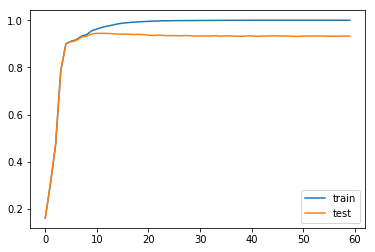

In [1157]:
plt.plot(range(60), train_ac, label='train')
plt.plot(range(60), test_ac, label='test')
plt.legend({'train' : 'b', 'test' : 'r'})
plt.show()



In [ ]:
NN_model.fit(NN_X_train, Y_train, epochs = 15, verbose = 1, validation_data=[NN_X_test, Y_test])


Train on 72000 samples, validate on 12000 samples
Epoch 1/15
72000/72000 [==============================] - 417s 6ms/step - loss: 1.4533 - acc: 0.4027 - val_loss: 1.4190 - val_acc: 0.3671
Epoch 2/15
72000/72000 [==============================] - 421s 6ms/step - loss: 1.2742 - acc: 0.4743 - val_loss: 1.2921 - val_acc: 0.4382
Epoch 3/15
62208/72000 [========================>.....] - ETA: 56s - loss: 1.2324 - acc: 0.4987

In [1105]:

CNN_model.fit(CNN_X_train,
             Y_train,
             batch_size=32,
             epochs=15,
             validation_data=(CNN_X_test,Y_test))

Train on 12000 samples, validate on 2000 samples
Epoch 1/15
12000/12000 [==============================] - 250s 21ms/step - loss: 1.7615 - acc: 0.3998 - val_loss: 1.4731 - val_acc: 0.4840
Epoch 2/15
12000/12000 [==============================] - 238s 20ms/step - loss: 1.3329 - acc: 0.5443 - val_loss: 1.1735 - val_acc: 0.5925
Epoch 3/15
12000/12000 [==============================] - 241s 20ms/step - loss: 1.1894 - acc: 0.5882 - val_loss: 1.2456 - val_acc: 0.5685
Epoch 4/15
12000/12000 [==============================] - 242s 20ms/step - loss: 1.1052 - acc: 0.6169 - val_loss: 1.0955 - val_acc: 0.6030
Epoch 5/15
12000/12000 [==============================] - 241s 20ms/step - loss: 1.0495 - acc: 0.6346 - val_loss: 0.9625 - val_acc: 0.6650
Epoch 6/15
12000/12000 [==============================] - 279s 23ms/step - loss: 1.0009 - acc: 0.6492 - val_loss: 1.0471 - val_acc: 0.6290
Epoch 7/15
12000/12000 [==============================] - 248s 21ms/step - loss: 0.9740 - acc: 0.6564 - val_loss: 0.8

In [1107]:
y_pred =  CNN_model.predict_classes(CNN_X_test, batch_size=32)

right = 0
count = 0
for i in range(10):
    for j in range(10):
        if i == j:
            right +=  output[i][j]
            count += 1
        if i == j - 1:
            right += output[i][j] 
            count += 1
        if i == j + 1:
            right += output[i][j]
            count += 1
print(count, right)
print(sum(sum(output)))
print("adjusted %", right/sum(sum(output)))
sklearn.metrics.confusion_matrix(y_test, y_pred)

28 8513
10000
0.8513


array([[149,   0,   0,   0,   3,   0,  11,  10,   0,  27],
       [  1, 198,   0,   0,   0,   0,   0,   1,   0,   0],
       [  2,   0, 175,   1,   4,   0,   5,   6,   0,   7],
       [  5,  10,  16, 104,   6,   6,   3,  29,   6,  15],
       [  8,   1,   6,   2, 155,   1,  11,   7,   0,   9],
       [  7,   0,   3,   8,  27, 116,   5,  22,   1,  11],
       [ 12,   0,   9,   0,  12,   6, 131,  13,   6,  11],
       [  6,   0,   1,   1,  13,   1,  12, 158,   0,   8],
       [ 22,   0,   6,   1,  11,  11,  20,  20,  83,  26],
       [ 14,   0,   0,   1,  13,   6,   4,  17,   2, 143]])

In [ ]:
#look at how to actually use these before appyling it
model3.add(Embedding(20000,128))
model3.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2))
model3.add(Dense(1,activation='sigmoid'))

In [666]:
print(AR_data_train.shape)
max_AR_data_train = np.max(AR_data_train, axis= 3)
print(max_AR_data_train.shape)

print(max(AR_data_train[1][0][0]))
print(np.mean(max_AR_data_train[0][:]))
print(np.mean(max_AR_data_train[1][:]))

(2, 1000, 1, 128)
(2, 1000, 1)
2.3611344532797256
2.7790092751573647
2.8100539360810797


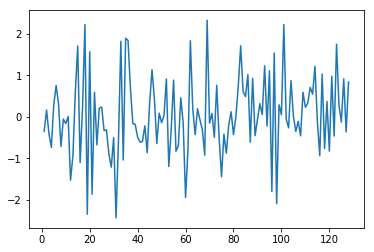

In [668]:
t = np.arange(1,r_len + 1).reshape(r_len)
plt.plot(t, AR_data_train[0][0].T)
plt.show()



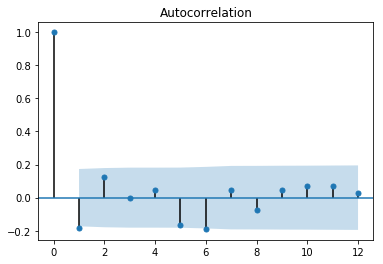

In [672]:
statsmodels.tsa.stattools.acf(AR_data_train[0][10])
#statsmodels.tsa.stattools.pacf(AR_data_train[1][0])

statsmodels.graphics.tsaplots.plot_acf(AR_data_train[0][0].T, lags = 12)
plt.show()

In [280]:
conf_band =1.96 / np.sqrt(100)
acf = statsmodels.tsa.stattools.acf(AR_data[4][1][0], nlags = 100) 
acf = acf * (abs(acf) - conf_band > 0)
acf

array([ 1.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.27484796,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.21437683, -0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.  

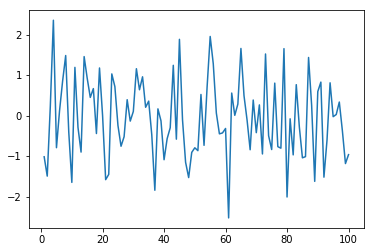

In [266]:
t = np.arange(1,101).reshape(100)
plt.plot(t, AR_data[1][10])

In [109]:
#might want to creat realizations of AR and MA using R!

def AR(p, sigma2 = 1, r_len = 100):
    """
    Creates an AR realization with set constant noise
    
    Arguements:
        p - the degree of the autoregressive component
        sigma2 - the set constant variation of the white noise
        r_len - the number of data points in the realization
        
    Returns:
        x_t - The AR(p) realization with connstant noice of variance eaqual to sigma
    """
    noise = np.random.normal(0,sigma2,r_len) #The noise at t of each x_t
    
    coefs = np.random.random(p) #The coefficients of AR polynomial of degree p

    x_t = np.random.normal(0,sigma2,p)  #Intitlizes x_t
    
    for i in range(r_len):
        next_xt = noise[i]
        for c in range(len(coefs)):
            next_xt += x_t[i - c + p - 1] * coefs[c]

        x_t = np.append(x_t,next_xt)

        
    return x_t[p:]

np.random.seed(1) 
AR(0, sigma2 = 1, r_len = 5)




array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763])